# Summary

In the previous notebook, we prepared the dataset (EDA). Now we are going to model our dataset using unsupervised methods.

This part of the project breaks down into two points:

. One concerning segmentation according to the RFM methodology

. The second focuses on the use of a clustering model and the temporal 
stability of the allocation of these clusters.


# Table of Contents

*   Summary
*   Table of Contents
*   Bibliography
*   Librairies and dataframe's Import
*   RFM Segmentation
*   Modeling
    1. Selecting Modeling Techniques
    2. Building the Models
       *   Preprocessing
       *   Detection of anomalies
       *   Reduction of dimensions
       *   Clustering
           *   KMeans
           *   K-Prototypes
           *   Dbuscan
           *   Ascending Hierarchical Classification
      *   Analysis of the different clusters
      *   K-Means temporal stability




















# Bibliography

yellowbrick : 
https://www.kaggle.com/kautumn06/yellowbrick-clustering-evaluation-examples

adjusted rand score : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

segmentation RFM : https://www.definitions-marketing.com/definition/segmentation-rfm/

silhouette coefficient : https://fr.wikipedia.org/wiki/Silhouette_(clustering)

K-prototype : https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf

IsolationForest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

KElbowVisualizer: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# **Librairies and dataframe's Import**

In [ ]:
# Common libraries for ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import datetime as dt
from datetime import datetime, timedelta, date
from pylab import figure, text, scatter, show

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Transformers
!pip install category_encoders 
import category_encoders as ce
from category_encoders import BaseNEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Regressors
!pip install sklearn
from sklearn.cluster import KMeans
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram 
from scipy.cluster.hierarchy import linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
!pip install umap-learn
import umap.umap_ as umap
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn import cluster

# Metrics 
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

     |████████████████████████████████| 82 kB 398 kB/s 
     |████████████████████████████████| 86 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 25.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=24659fd9093ce1b7379fbe2a476685637b4889e3ae02fab644e2198c87db2b38
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=c0e18ad126fa1c36c639c426739fe744e6e777ababc3308265339d375e03c762
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/olist_new_dataset',low_memory=False)

In [ ]:
data.head(4)

,customer_unique_id,index,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,order_time,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
0,0000366f3b9a7992bf8c76cfdf3221e2,0,1,129.90,12.00,1.0,8.0,5.0,6.0,1525949787000000000,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7787,cajamar,São Paulo,São Paulo,210.155490
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,8.29,1.0,1.0,4.0,3.0,1525691487000000000,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6053,osasco,São Paulo,São Paulo,210.155490
2,0000f46a3911fa3c0805444483337064,2,1,69.00,17.22,1.0,8.0,3.0,26.0,1489179903000000000,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,88115,sao jose,Santa Catarina,Santa Catarina,125.481181
3,0000f6ccb0745a6a4b88665a16c9f078,3,1,25.99,17.63,1.0,4.0,4.0,20.0,1507840181000000000,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,66812,belem,Pará,Pará,1571.715882


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            93358 non-null  object 
 1   index                         93358 non-null  int64  
 2   nb_orders                     93358 non-null  int64  
 3   total_spend                   93358 non-null  float64
 4   total_freight                 93358 non-null  float64
 5   mean_payment_sequential       93358 non-null  float64
 6   mean_payment_installments     93358 non-null  float64
 7   mean_review_score             93358 non-null  float64
 8   delivery_days                 93358 non-null  float64
 9   order_time                    93358 non-null  int64  
 10  favorite_sale_month           93358 non-null  int64  
 11  books_cds_media               93358 non-null  float64
 12  fashion_clothing_accessories  93358 non-null  float64
 13  f

# **RFM Segmentation**

RFM Analysis is a data-driven customer behavior segmentation technique where RFM stands for recency, frequency, and Monetary.

The idea is to segment customers based on the date of their last purchase (Recency), how often they bought in the past (Frequency) and how much they spent (Monetary). These three metrics are effective predictors of a customer's willingness to respond to marketing messages and offers.

In [ ]:
# Importing the dataset changed variables of type datetime64 [ns] 
# to object. It is necessary to reconvert the corresponding variables.
data['order_time'] = data['order_time'].astype('datetime64[ns]')

In [ ]:
def calculateRFM(data):
    """ 
    Function allowing to generate the three variables Recency,
    Frequency and Currency. Specific to RFM segmentation.
    
    """

    # Aggregate data by each customer
    rfm = data.groupby(['customer_unique_id']).agg({
        'order_time': lambda x: (today - x.max()).days,
        'nb_orders': 'count',
        'total_spend': 'sum'})

    # Rename columns
    rfm.rename(columns={'order_time': 'Recency',
                        'nb_orders': 'Frequency',
                        'total_spend': 'Monetary'}, inplace=True)
    return rfm

In [ ]:
def hist_rfm(rfm):
    """
    Function allowing to generate histograms of variables R, F and M
    
    """
    fig = plt.figure(1, figsize=(15, 4))

    # Histogram of Recency variable
    plt.subplot(1, 3, 1)
    sns.distplot(rfm.Recency, label='Recency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogram of the variable Frequency
    plt.subplot(1, 3, 2)
    sns.distplot(rfm.Frequency, label='Frequency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogram of the Monetary variable
    plt.subplot(1, 3, 3)
    sns.distplot(rfm.Monetary, label='Monetary',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

In [ ]:
def boxplot_rfm(rfm):
    """ 
    Boxplot of variables R, F and M
    
    """
    fig = plt.figure(1, figsize=(18, 4))

    # Boxplot of variable Recency
    plt.subplot(131)
    sns.boxplot(rfm["Recency"], orient="vertical")

    # Boxplot of variable Frequency
    plt.subplot(132)
    sns.boxplot(rfm["Frequency"], orient="vertical")

    # Boxplot of variable Monetary
    plt.subplot(133)
    sns.boxplot(rfm["Monetary"], orient="vertical")
    plt.show()

In [ ]:
today = data['order_time'].max()

In [ ]:
# Applying the RFM Function to df
rfm = calculateRFM(data)

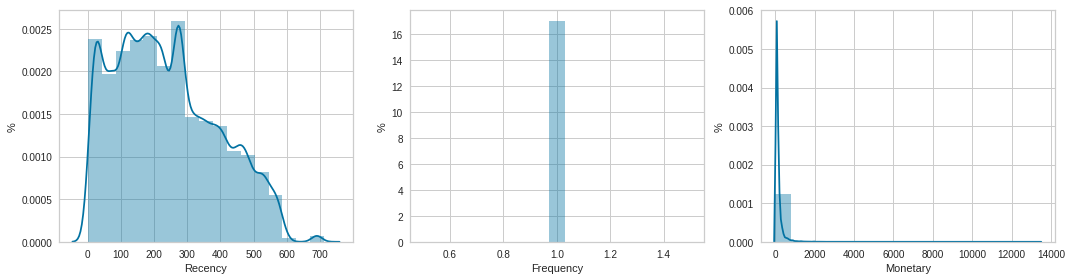

In [ ]:
# Application of the RFM histogram function to df
hist_rfm(rfm)

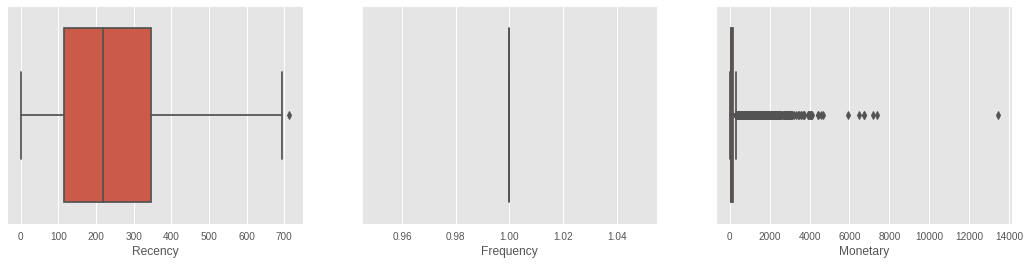

In [ ]:
# Applying the RFM boxplot function to df
boxplot_rfm(rfm)

The histograms of these three variables clearly show their abnormal distribution while the boxplots clearly show the presence of outliers for the monetary variable which we have already explained in the 1 st notebook.

In [ ]:
def rfm_score(x, quintiles, c):
    """
    Assigns a score between 1 and 5 depending on the location of x by
    compared to quintiles. The larger x is, the greater the score
    
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [ ]:
quintiles = rfm[['Recency',
                 'Frequency',
                 'Monetary']].quantile([.2, .4, .6, .8])

In [ ]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, ['5','4','3','2','1']).astype(np.int64)

rfm['F'] = rfm['Frequency'].apply(lambda x:
                                  rfm_score(x, quintiles, 'Frequency'))

rfm['M'] = pd.qcut(rfm['Monetary'], 5, ['5','4','3','2','1']).astype(np.int64)

In [ ]:
def calculSegment(rfm):
    """
    Returns the segment associated with the customer based on their score for 
    the R, F and M variables

    """

    if 4 <= rfm["R"] <= 5 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Champions"

    elif 3 <= rfm["R"] <= 5 and 3 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["R"] <= 5 and 1 <= rfm["F"] <= 3 and 1 <= rfm["M"] <= 3:
        return "Potential Loyalist"

    elif rfm["R"] >= 4 and rfm["F"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["R"] <= 4 and rfm["F"] <= 1 and rfm["M"] <= 1:
        return "Promising"

    elif 2 <= rfm["R"] <= 3 and 2 <= rfm["F"] <= 3 and 2 <= rfm["M"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["R"] <= 3 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "About To Sleep"

    elif rfm["R"] <= 1 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Can't Lose Them"

    elif rfm["R"] <= 2 and 2 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "At Risk"

    elif rfm["R"] <= 2 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "Lost"

    else:
        return "Others"

In [ ]:
rfm["RFM Score"] = rfm.apply(calculSegment, axis=1)

In [ ]:
rfm.head(5)

,Recency,Frequency,Monetary,R,F,M,RFM Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,2,Potential Loyalist
0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,4,1,5,Recent Customers
0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,4,Others
0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,5,Others
0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,1,About To Sleep


In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93358 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    93358 non-null  int64  
 1   Frequency  93358 non-null  int64  
 2   Monetary   93358 non-null  float64
 3   R          93358 non-null  int64  
 4   F          93358 non-null  int64  
 5   M          93358 non-null  int64  
 6   RFM Score  93358 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 5.7+ MB


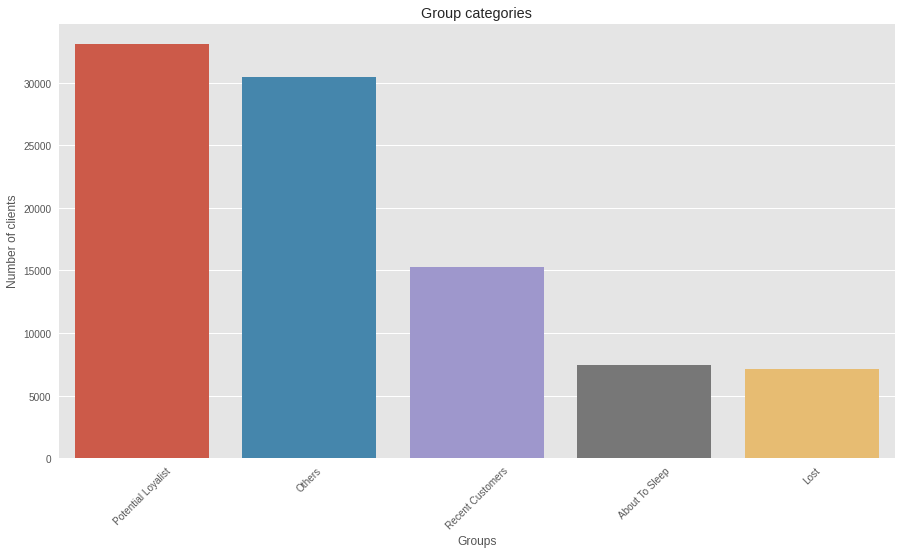

In [ ]:
# To graph RFM score groups
x = list(rfm["RFM Score"].value_counts().index)
y = rfm["RFM Score"].value_counts().values

fig = plt.figure(figsize=(15, 8))
plt.title("Group categories")
plt.xlabel("Groups")
plt.xticks(rotation=45)

plt.ylabel("Number of clients")
sns.barplot(x, y)
plt.show()

According to RFM segmentation, the two dominant categories of customers are potential loyalists and others.

___

#**Modeling**

### **1. Selecting Modeling Techniques**

**Detection of anomalies** : IsolationForest

**Reduction of dimensions** : PCA, TSNE, Isomap, Umap

**Clustering** : K-Means, K-Prototypes, Dbuscan, Ascending Hierarchical Classification

### **2. Building the Models**



**Preprocessing**

We are going to remove customer_zip_code_prefix and customer_city, 
customer_state to keep only the variable haversine_distance to indicate a "large" location of customers, which will avoid focusing the 
segmentation on the location of the customer.

Also we are going to delete customer_unique_id.

In [ ]:
data = data.drop(data[['customer_unique_id', 'zip_code_prefix', 'customer_city', 
                       'customer_state','Flag and name']], axis=1)

For clustering, we will delete the variable 'order_time' which does not seem very interesting.

In [ ]:
df = data.drop(data[['order_time','index']], axis=1)

In [ ]:
# Definition of categorical variables
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
cat_cols

Index([], dtype='object')

In [ ]:
# Definition of numerical variables
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['nb_orders', 'total_spend', 'total_freight', 'mean_payment_sequential',
       'mean_payment_installments', 'mean_review_score', 'delivery_days',
       'favorite_sale_month', 'books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby', 'total_items', 'harvesine_distance'],
      dtype='object')

Then we prepare the preprocessor to scale all points.

In [ ]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, num_cols)])

In [ ]:
X = preprocessor.fit((df))
X = preprocessor.transform((df))

___

# **Detection of anomalies**

Anomaly detection is a step in data mining that identifies data points, events, and/or observations that deviate from a dataset’s normal behavior.

So before starting client clustering, we must eliminate any anomalies that can disrupt our clusters.

For this, we will use Isoloation Forest. The IsolationForest ‘isolates’ 
observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [ ]:
model = IsolationForest(random_state=0, contamination=0.05)
model.fit(X)

IsolationForest(contamination=0.05, random_state=0)

Contamination is the proportion of outliers in the data set. Anomalies 

will be represented by the number -1.

In [ ]:
outliers = model.predict(X) == -1

In [ ]:
df[outliers].head(4)

,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
9,1,104.90,24.86,1.0,4.0,1.0,54.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1521.235791
104,2,317.89,36.48,1.0,2.0,5.0,7.0,7,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,430.310239
124,1,949.99,43.56,1.0,10.0,3.0,10.0,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1571.715882
164,1,267.20,33.40,1.0,3.0,1.0,52.0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,430.310239


In [ ]:
df[outliers].shape

(4668, 20)

4668 points are considered anomalies. Now we are going to remove these 

points.

In [ ]:
index_to_drop = df[outliers].index

In [ ]:
df.drop(index_to_drop,0, inplace=True)

In [ ]:
df.shape

(88690, 20)

___

# **Reduction of dimensions**

The goal of all dimension reduction algorithms is to determine a space 
of smallest dimension while preserving the distances between points.

In our study we will do a reduction of dimensions in order to then make a comparison between clustering on real data and clustering on reduced data, in order to compare their performance in terms of metrics and computation time.


**Principal component analysis** is a method widely used in dimension 
reduction that seeks to represent data in a close hyperplane so as to 
keep the variance of the data cloud as much as possible. In other 
words, it is about representing the data in a subspace of smaller 
dimension maximizing the total inertia of the cloud projected in that 
space. 

**t-distributed stochastic neighbor embedding (t-SNE)** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. The t-SNE algorithm consists in creating a probability distribution that represents the similarities between neighbors in a high-dimensional space and in a smaller-dimensional space.

**Isomap** is used for computing a quasi-isometric, low-dimensional 
embedding of a set of high-dimensional data points. The algorithm 
provides a simple method for estimating the intrinsic geometry of a 
data manifold based on a rough estimate of each data point's neighbors 
on the manifold.

**Uniform Manifold Approximation and Projection (UMAP)** is a dimension 
reduction technique that can be used for visualisation similarly to 
t-SNE, but also for general non-linear dimension reduction. The 
algorithm is founded on three assumptions about the data.







In [ ]:
# reducers dictionary
dict_reducer = {
    'PCA' : PCA(),
    'Isomap' : Isomap(n_jobs=-1),
    'UMAP' : umap.UMAP(),
    'TSNE' : TSNE()
}

To facilitate the work and reduce the execution time, we will work on a sample of the dataframe.

In [ ]:
# To return a random sample from dataframe
new_data = df.sample(frac=0.2, random_state=42)

In [ ]:
X = preprocessor.fit(new_data)

In [ ]:
X = preprocessor.transform(new_data)

In [ ]:
# Function allowing to test several reducers on the same dataframe
def dimensionality_reduction(data_scaled, reducer):
    reducer = reducer
    
    if reducer == PCA():
        
        cum_expl_var_ratio = np.cumsum(reducer.explained_variance_ratio_)
        num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])
        # return PCA with components that explain 80% of the variance

        pca = PCA(num_components).fit(data_scaled)
        data_pca = pca.transform(data_scaled)
        data_pca = pd.DataFrame(data_pca)
        data_reduced = data_pca
        return data_reduced
        
    else :
        
        data_reduced = reducer.fit_transform(data_scaled)
        return data_reduced

In [ ]:
# Dictionary of reduced dataframes
dict_data_reduced = {}

for name_reducer, reducer in dict_reducer.items():
    dict_data_reduced[name_reducer] = dimensionality_reduction(X, reducer)

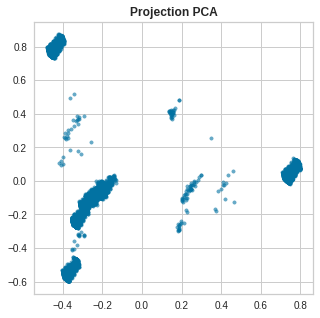

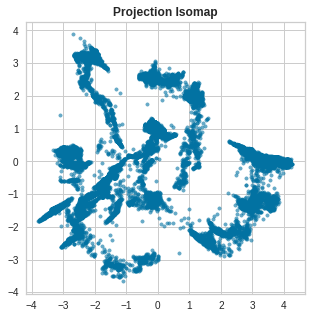

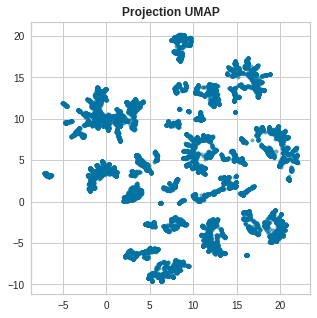

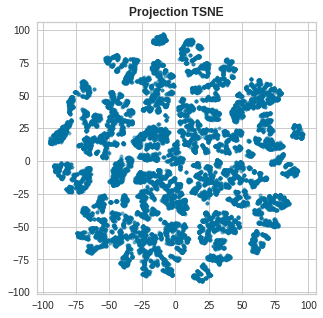

In [ ]:
# 2D projection in the new reduced planes
for name_reducer, data_reduced in dict_data_reduced.items():

    df_reduced = pd.DataFrame(dict_data_reduced[name_reducer])

    plt.figure(figsize=(5, 5))
    plt.scatter(df_reduced.loc[:, 0], df_reduced.loc[:, 1], alpha=0.6, 
                marker='.')
    plt.title('Projection {}'.format(name_reducer), fontsize=12, weight='bold')
    
    plt.show()

Dataframe reduction with UMAP generates dense and separated clusters. 

Now we will implement the clustering algorithms with the initial data  

then with reduced data to determine the different clusters. 

___

# **Clustering**

**K-Means**

K-Means is a simple unsupervised machine learning algorithm that groups data 

into the number  K  of clusters specified by the user, even if it is not the 

optimal number of clusters for the dataset.


**K-Means with intial data**

In the first place, it is necessary to scale all points after having eliminated

all the anomalies.

In [ ]:
X = preprocessor.fit((df))
X = preprocessor.transform((df))

In [ ]:
# Calcul of inertia with different values of K
inertia = []
K_range = range(1,20)
for k in K_range:
  model = KMeans(n_clusters=k).fit(X)
  inertia.append(model.inertia_)

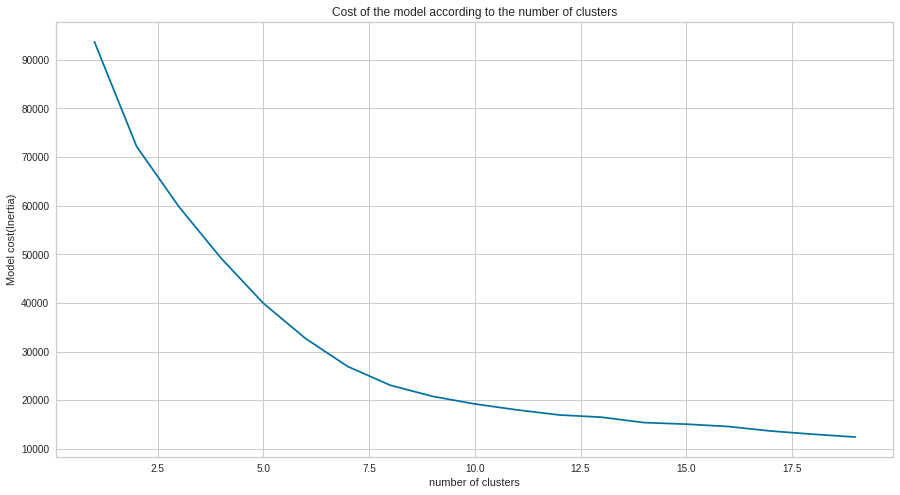

In [ ]:
# To plot inertia according to the number of clusters
fig = plt.figure(figsize=(15, 8))
plt.plot(K_range, inertia)
plt.xlabel('number of clusters')
plt.ylabel('Model cost(Inertia)')
plt.title('Cost of the model according to the number of clusters')
plt.show()

The optimal number of clusters is not clear where we will use the 
KElbowVisualizer method to determine it.

Yellowbrick's KElbowVisualizer implements the “elbow” method of selecting the optimal number of clusters by fitting the K-Means model with a range of values for  K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

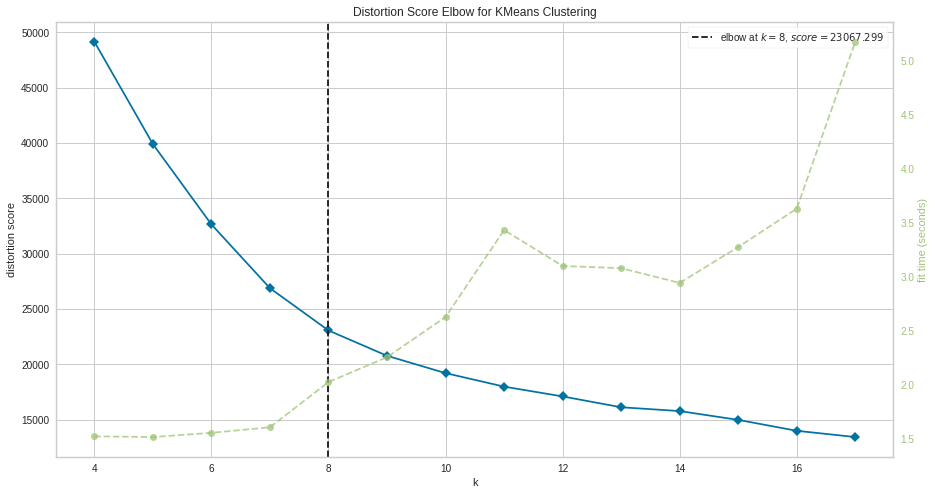

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,18))
fig = plt.figure(figsize=(15, 8))
visualizer.fit(X)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/poof the data

From KElbowVisualizer k optimal = 8

**Silhouettes Plots**

The silhouette coefficient is a measure of the quality of a partition of a set of data in automatic classification. For each point, its silhouette coefficient is the difference between the average distance with the points of the same group as it (cohesion) and the average distance with the points of the other neighboring groups (separation). If this difference is negative, the point is on average closer to the neighboring group than to its own: it is therefore poorly classified. Conversely, if this difference is positive, the point is on average closer to its group than to the neighboring group: it is therefore well classified.

The silhouette coefficient itself is the average of the silhouette coefficient for all points.

For n_clusters = 2 The average silhouette_score is : 0.25093060632324243
For n_clusters = 3 The average silhouette_score is : 0.3336863789607587
For n_clusters = 4 The average silhouette_score is : 0.40560263377295763
For n_clusters = 5 The average silhouette_score is : 0.4695506905938736
For n_clusters = 6 The average silhouette_score is : 0.5194327089958914
For n_clusters = 7 The average silhouette_score is : 0.5595410110867463
For n_clusters = 8 The average silhouette_score is : 0.5857074923135832
For n_clusters = 9 The average silhouette_score is : 0.5204636073979402


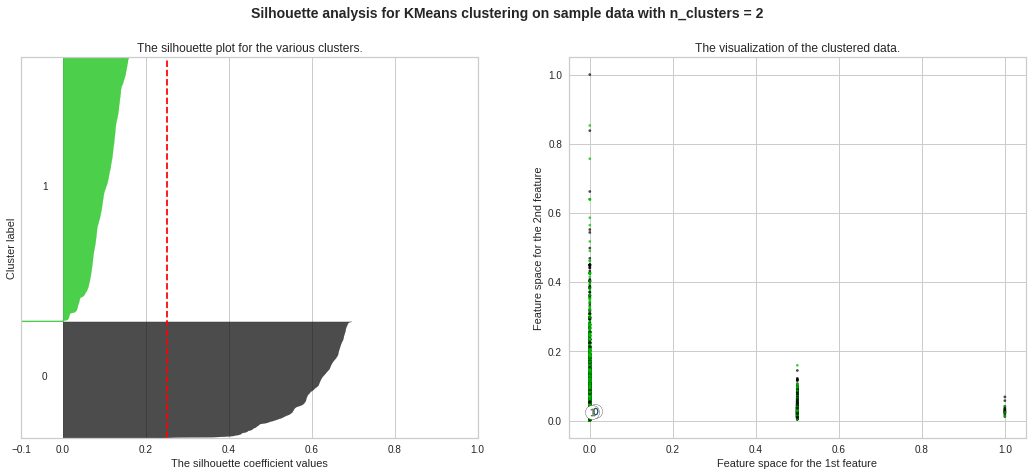

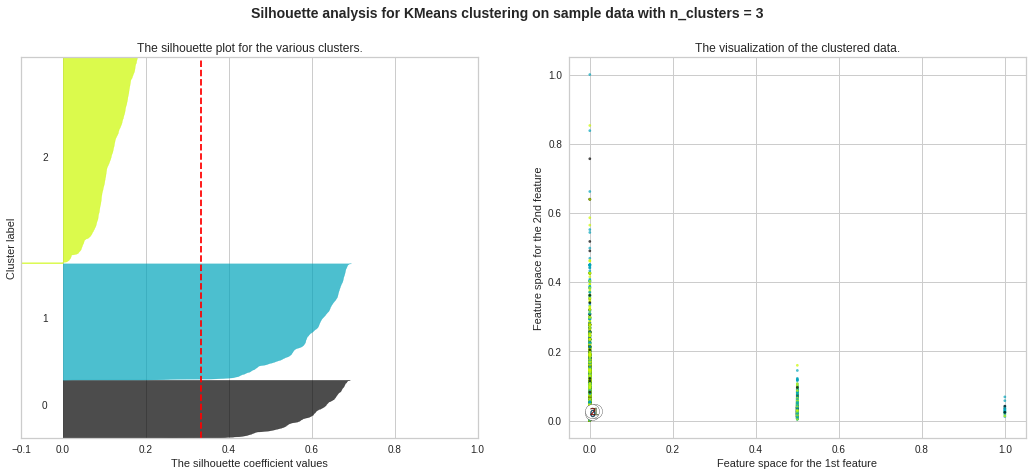

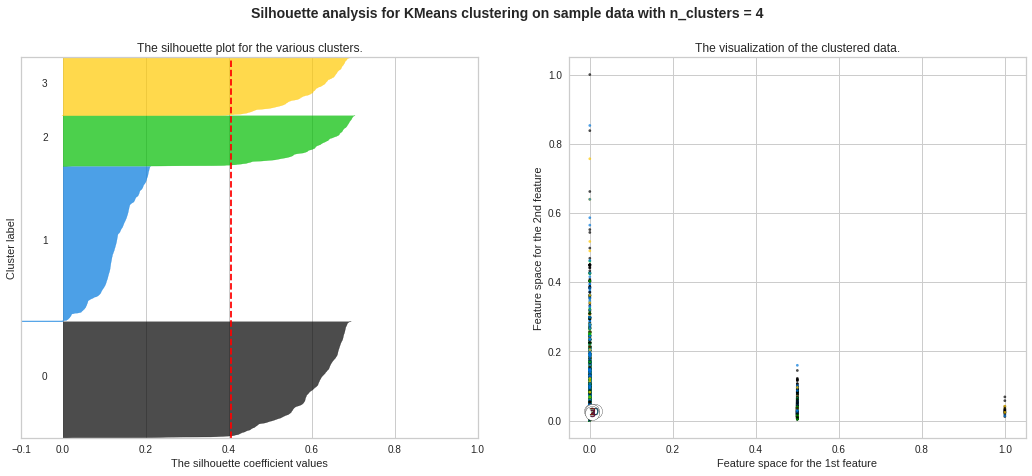

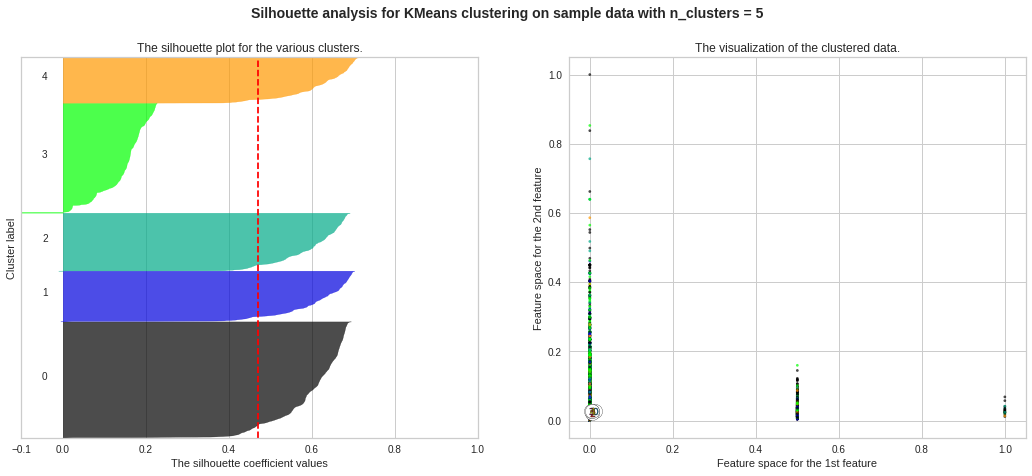

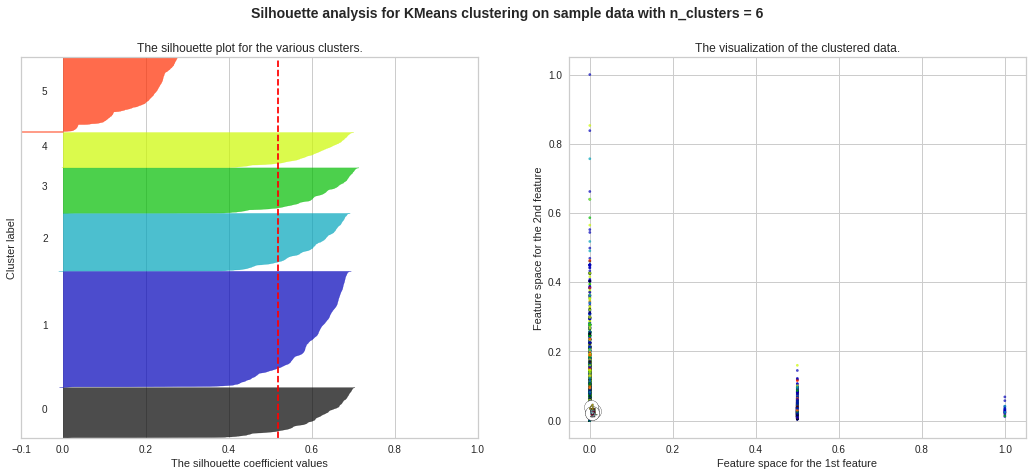

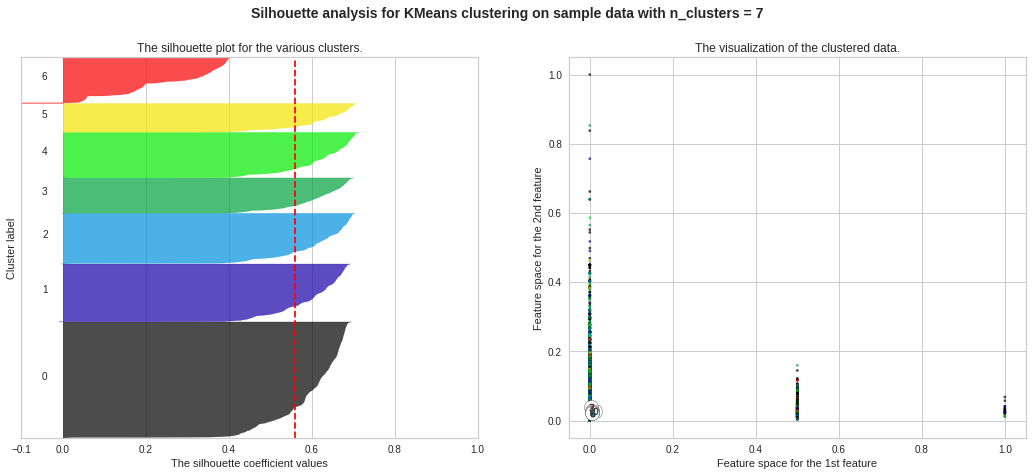

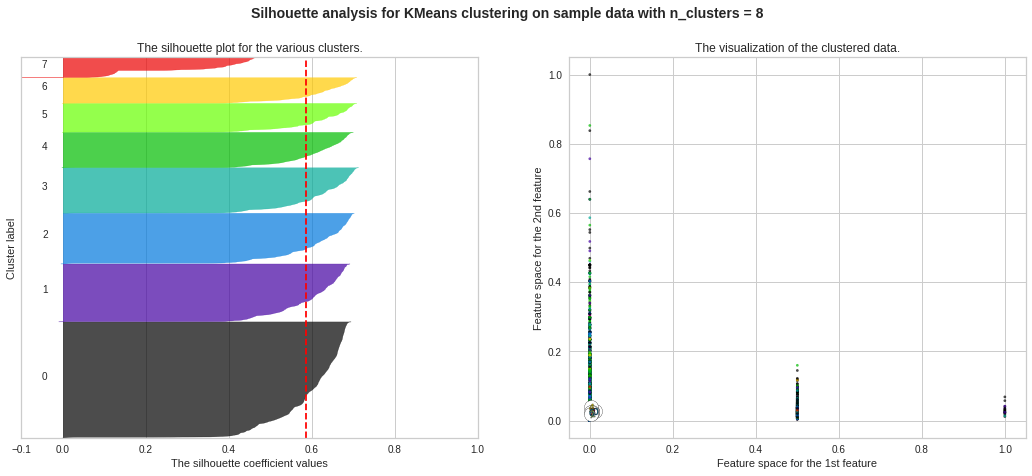

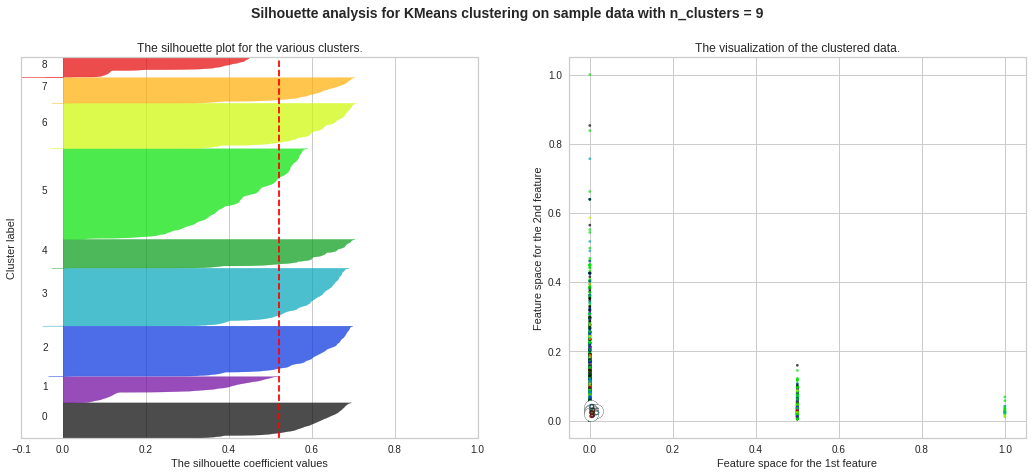

In [ ]:
import matplotlib.cm as cm

range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++',
                       max_iter=1000)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0,
                alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Thanks to the bend method based on the distortion score (mean sum of the squares of the distances to the centers) and the silhouette coefficient a segmentation in K = 8 clusters would be the best option.

In [ ]:
# Choose clustering with kmeans  
myclust = cluster.KMeans(n_clusters=8)
myclust.fit(X)
myclust.predict(X)
myclust.score(X)

-23067.299509268298

The objective in the K-means is to reduce the sum of squares of the distances of points from their respective cluster centroids. This value tells how internally coherent the clusters are. ( The less the better)

**Homogeneity and completeness metrics**

Homogeneity:

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

Completeness:

A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.


In [ ]:
labels = myclust.labels_

In [ ]:
# Number of clusters in labels
labels_true = df.index
n_clusters_ = len(set(labels)) 

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 8
Homogeneity: 0.1689
Completeness: 1.0000
Silhouette Coefficient: 0.5857


**Distances intercluster**

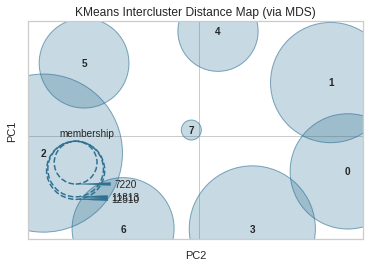

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(8)))])
distance_visualizer.fit(data)
distance_visualizer.named_steps['distancevisualizer'].show()

On this projection in 2D, we notice that the various clusters are not very well separated on the first 2 principal components. 

**K-Means with reduced data**

In [ ]:
reducer = umap.UMAP() 
data_umap = reducer.fit_transform(X)

In [ ]:
# Calcul of inertia with different values of K
inertia = []
K_range = range(1,20)
for k in K_range:
  model = KMeans(n_clusters=k).fit(data_umap)
  inertia.append(model.inertia_)

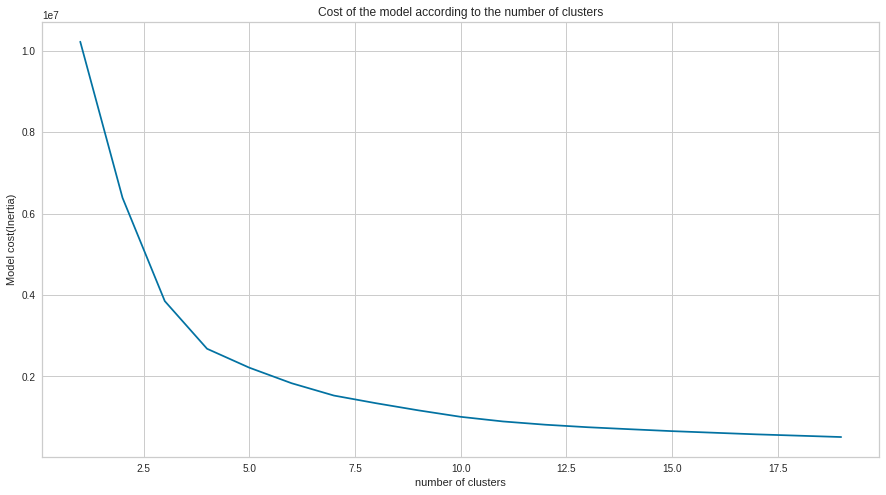

In [ ]:
# To plot inertia according to the number of clusters
fig = plt.figure(figsize=(15, 8))
plt.plot(K_range, inertia)
plt.xlabel('number of clusters')
plt.ylabel('Model cost(Inertia)')
plt.title('Cost of the model according to the number of clusters')
plt.show()

The optimal number of clusters is not clear where we will use the 
KElbowVisualizer method to determine it.



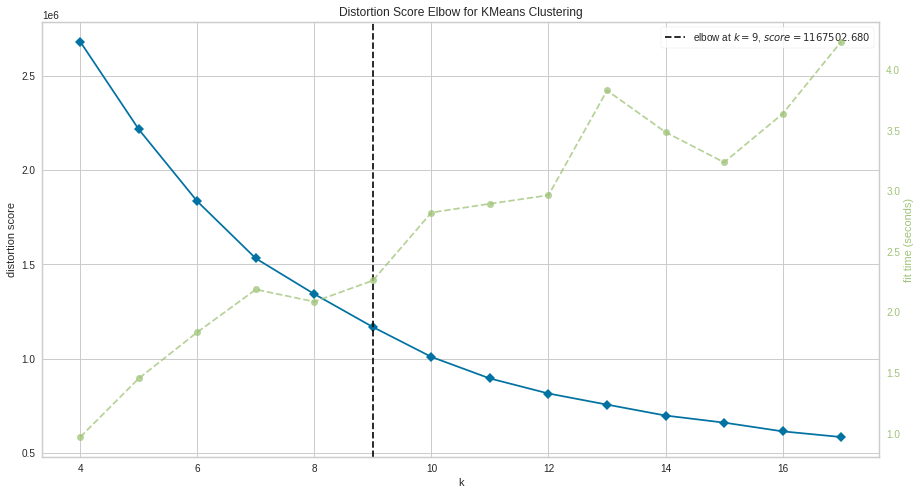

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,18))
fig = plt.figure(figsize=(15, 8))
visualizer.fit(data_umap)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/poof the data

**Silhouettes Plots**

For n_clusters = 2 The average silhouette_score is : 0.35759702
For n_clusters = 3 The average silhouette_score is : 0.3975184
For n_clusters = 4 The average silhouette_score is : 0.39841852
For n_clusters = 5 The average silhouette_score is : 0.37363783
For n_clusters = 6 The average silhouette_score is : 0.39923134
For n_clusters = 7 The average silhouette_score is : 0.38219118
For n_clusters = 8 The average silhouette_score is : 0.38447383
For n_clusters = 9 The average silhouette_score is : 0.3847973


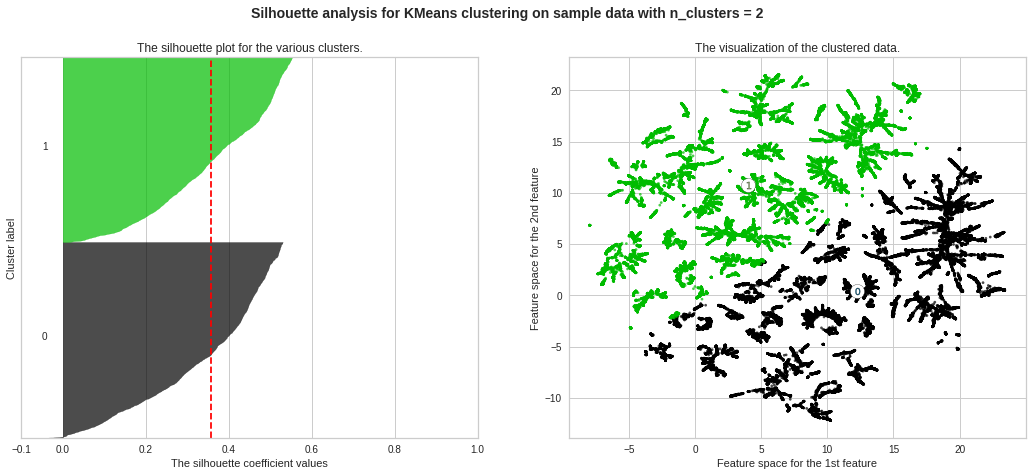

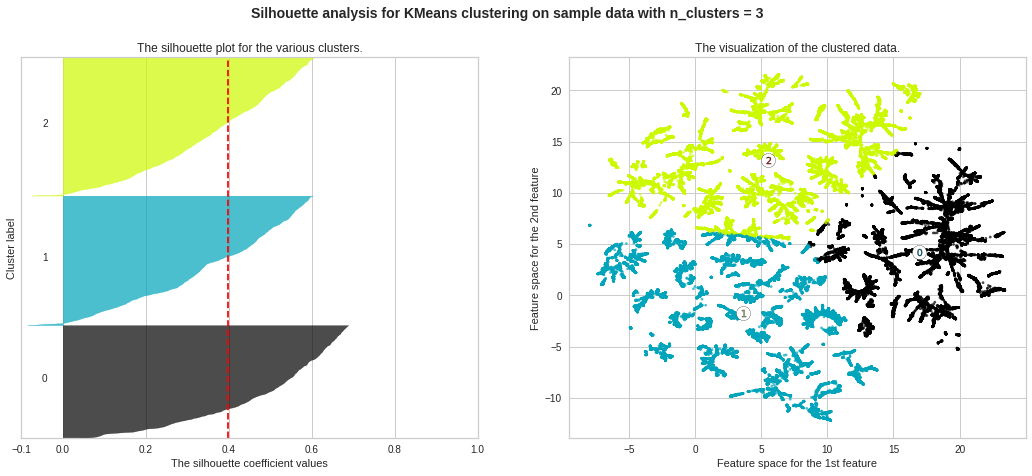

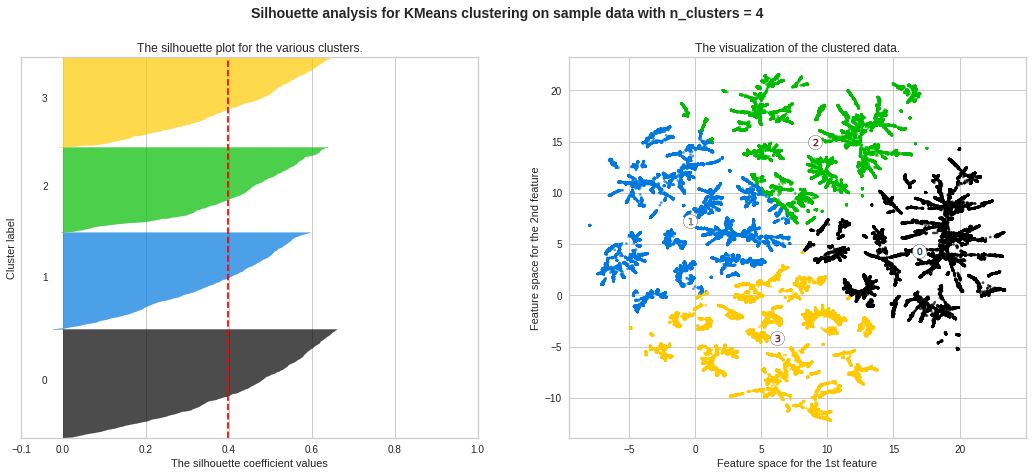

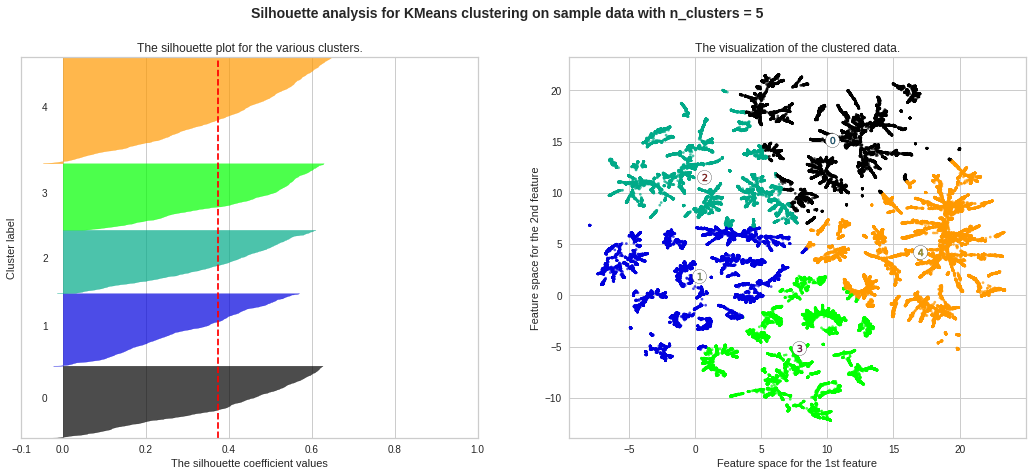

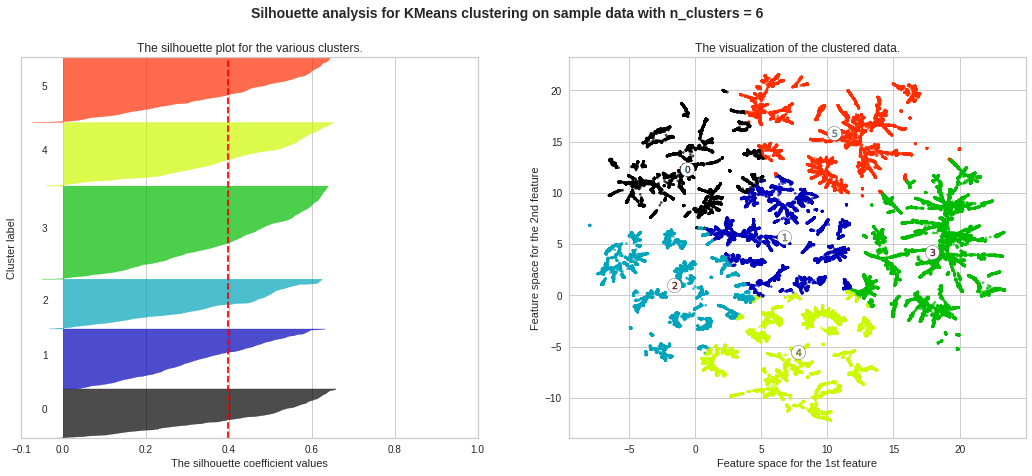

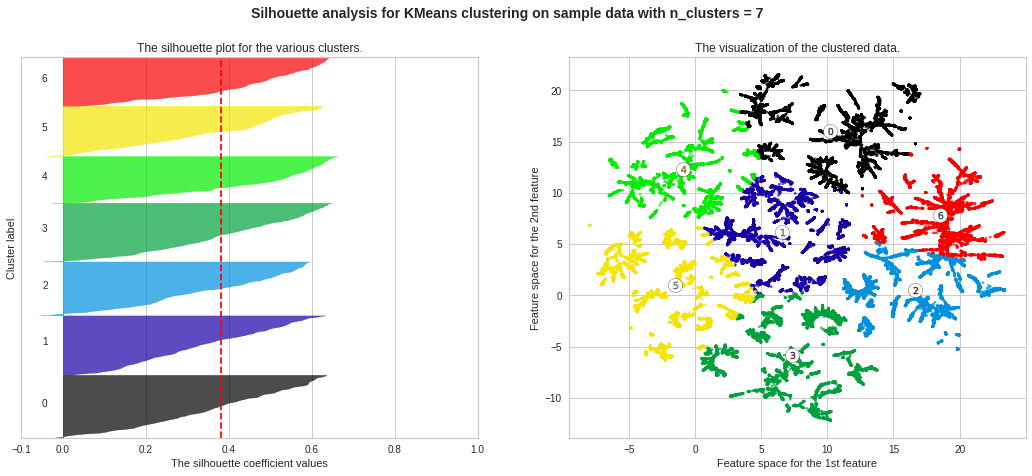

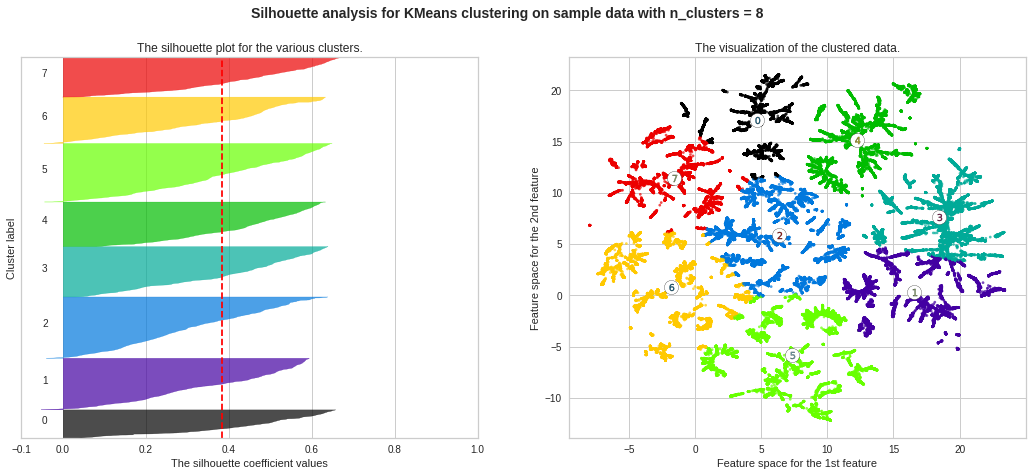

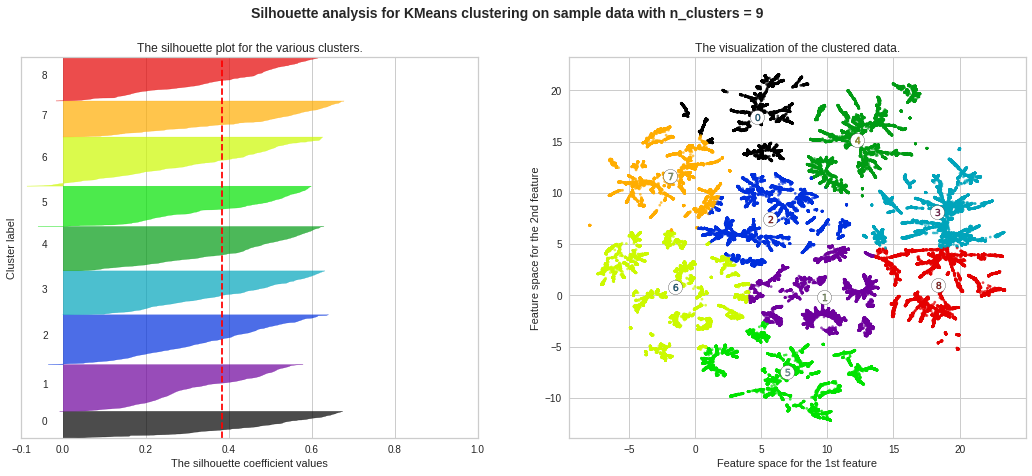

In [ ]:
import matplotlib.cm as cm

range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(data_umap) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++',
                       max_iter=1000)
    cluster_labels = clusterer.fit_predict(data_umap)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_umap, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_umap, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_umap[:, 0], data_umap[:, 1], marker='.', s=30, lw=0,
                alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Thanks to the silhouette analysis, a segmentation in K = 6 clusters  
would be the best option.

In [ ]:
# Choose clustering with kmeans  
myclust = cluster.KMeans(n_clusters=6)
myclust.fit(data_umap)
myclust.predict(data_umap)
myclust.score(data_umap)

-1833454.375

In [ ]:
labels = myclust.labels_

In [ ]:
# Number of clusters in labels
labels_true = df.index
n_clusters_ = len(set(labels)) 

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))

Estimated number of clusters: 6
Homogeneity: 0.1551
Completeness: 1.0000


**Distances intercluster**

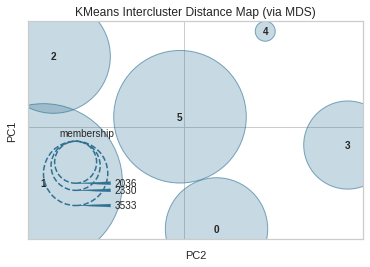

In [ ]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(6)))])
distance_visualizer.fit(new_data)
distance_visualizer.named_steps['distancevisualizer'].show()

By comparing the clustering on real data and that carried out on reduced data, we notice that we have not gained in terms of metrics or in terms of computing time.

___

**K-Prototypes**

The K-Prototype is the clustering algorithm which is the combination of K-Means and K-Mode. In the K-modes algorithm, distance is measured by the number of common categorical attributes shared by the two data points. K-Prototypes measures the distance between numeric variables using Euclidean distance (like K-Means), but also measures the distance between categorical entities using the number of corresponding categories. The main steps are as follows: 

1. Select k initial prototypes from the X dataset. There should be one for each cluster. 

2. Allocate each object of X to a cluster whose prototype is closest to it. This allocation is made by considering the dissimilarity measure. 

3. Once all the objects have been allocated to a cluster, test again the similarity of the objects to the current prototypes. If an individual is closer to another cluster, the prototypes of both clusters are updated.

For this algorithm dealing with mixed data, we are going to convert some variables into categorical variables (like the months of purchase for example) to give them more meaning.

**K-Prototypes with initial data**

In [ ]:
X_Pro = df.copy()
X_Pro["favorite_sale_month"] = pd.to_datetime(X_Pro["favorite_sale_month"], 
                                              format='%m').dt.month_name()
X_Pro["mean_payment_sequential"] = np.where(X_Pro["mean_payment_sequential"] >1
                                            ,"Multiple", "Single")
X_Pro["mean_payment_installments"] = np.where(
    X_Pro["mean_payment_installments"] > 1, "Multiple", "Single")
X_Pro.head(4)

,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
0,1,129.90,12.00,Single,Multiple,5.0,6.0,May,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,210.155490
1,1,18.90,8.29,Single,Single,4.0,3.0,May,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,210.155490
2,1,69.00,17.22,Single,Multiple,3.0,26.0,March,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,125.481181
3,1,25.99,17.63,Single,Multiple,4.0,20.0,October,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1571.715882


For the K-Prototypes algorithm, we don't need to encode categorical variables. 
We will therefore normalize only the numerical variables

In [ ]:
for c in X_Pro.select_dtypes(exclude="object").columns:
    scaler = MinMaxScaler()
    X_Pro[c] = scaler.fit_transform(np.array(X_Pro[c]).reshape(-1, 1))

In [ ]:
# Categorical features index
cat_cols = [X_Pro.columns.get_loc(c) 
           for c in X_Pro.select_dtypes(include="object").columns]

In [ ]:
# Choosing optimal K
cost = []
for num_clusters in list(range(4,9)):
    n_clusters = num_clusters
    myclust = KPrototypes(n_clusters, init='Cao',n_init=1,verbose=1)
    myclust.fit_predict(X_Pro, categorical=cat_cols)
    cost.append(myclust.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 19819, ncost: 63787.19308540603
Run: 1, iteration: 2/100, moves: 7624, ncost: 60763.39333535411
Run: 1, iteration: 3/100, moves: 94, ncost: 60763.31583407547
Run: 1, iteration: 4/100, moves: 0, ncost: 60763.31583407547
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 10812, ncost: 54328.087200009904
Run: 1, iteration: 2/100, moves: 6885, ncost: 50799.675831706554
Run: 1, iteration: 3/100, moves: 469, ncost: 50781.48831999596
Run: 1, iteration: 4/100, moves: 2, ncost: 50781.488060677104
Run: 1, iteration: 5/100, moves: 0, ncost: 50781.488060677104
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 30139, ncost: 55740.38131635168
Run: 1, ite

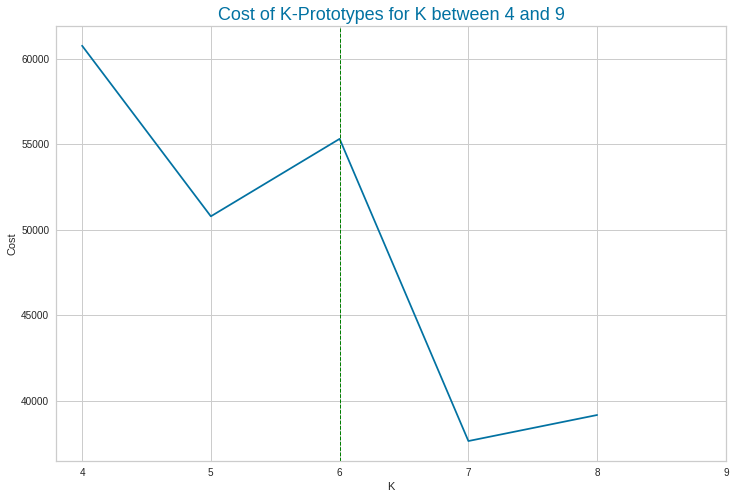

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(cost)
plt.xticks(np.arange(0,6,1), np.arange(4,10,1))
plt.axvline(x=2, linestyle="--", 
            color="green",
            linewidth=1)
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("Cost of K-Prototypes for K between 4 and 9",
          fontsize=18, color="b")
plt.show()

Then we initialize the algorithm with 6 clusters.

In [ ]:
myclust = KPrototypes(n_clusters= 6, init='Cao',n_init=1,verbose=1)
myclust_labels = myclust.fit_predict(X_Pro, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 37553, ncost: 50054.144763505275
Run: 1, iteration: 2/100, moves: 7549, ncost: 49063.09209154982
Run: 1, iteration: 3/100, moves: 1322, ncost: 48980.97785255592
Run: 1, iteration: 4/100, moves: 45, ncost: 48980.95469444841
Run: 1, iteration: 5/100, moves: 0, ncost: 48980.95469444841


In [ ]:
# Number of clusters in labels
labels_true = X_Pro.index
n_clusters_ = len(set(myclust_labels))

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" 
      % metrics.homogeneity_score(labels_true, myclust_labels))
print("Completeness: %0.4f"
      % metrics.completeness_score(labels_true, myclust_labels))

Estimated number of clusters: 6
Homogeneity: 0.1509
Completeness: 1.0000
Silhouette Coefficient: -0.0679


**K-Prototypes with reduced data**

In [ ]:
X_Pro = data_umap.copy()
X_Pro["favorite_sale_month"] = pd.to_datetime(X_Pro["favorite_sale_month"], 
                                              format='%m').dt.month_name()
X_Pro["mean_payment_sequential"] = np.where(X_Pro["mean_payment_sequential"] >1
                                            ,"Multiple", "Single")
X_Pro["mean_payment_installments"] = np.where(
    X_Pro["mean_payment_installments"] > 1, "Multiple", "Single")
X_Pro.head(4)

,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
81989,3,62.98,25.29,Single,Single,5.0,5.0,July,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,3.0,210.155490
41329,1,60.90,14.60,Single,Single,5.0,11.0,May,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,493.119438
23031,1,400.00,50.24,Single,Multiple,4.0,27.0,December,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1485.279622
88191,1,127.00,18.47,Single,Single,2.0,36.0,March,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,669.323806


In [ ]:
for c in X_Pro.select_dtypes(exclude="object").columns:
    scaler = MinMaxScaler()
    X_Pro[c] = scaler.fit_transform(np.array(X_Pro[c]).reshape(-1, 1))

In [ ]:
# Categorical features index
cat_cols = [X_Pro.columns.get_loc(c) 
           for c in X_Pro.select_dtypes(include="object").columns]

In [ ]:
# Choosing optimal K
cost = []
for num_clusters in list(range(4,9)):
    n_clusters = num_clusters
    myclust = KPrototypes(n_clusters, init='Cao',n_init=1,verbose=1)
    myclust.fit_predict(X_Pro, categorical=cat_cols)
    cost.append(myclust.cost_)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2296, ncost: 12673.219624094205
Run: 1, iteration: 2/100, moves: 683, ncost: 12510.877906106689
Run: 1, iteration: 3/100, moves: 2, ncost: 12510.877288857817
Run: 1, iteration: 4/100, moves: 0, ncost: 12510.877288857817
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4150, ncost: 10042.819321847908
Run: 1, iteration: 2/100, moves: 84, ncost: 10039.570191890916
Run: 1, iteration: 3/100, moves: 2, ncost: 10039.568562147831
Run: 1, iteration: 4/100, moves: 0, ncost: 10039.568562147831
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4193, ncost: 10606.627350719078
Run: 1, iteration: 2/100, moves: 542, ncost: 10496.596978174788
Run: 1, iteration: 3/100, moves: 287, ncost: 10434.603577020234
Run: 

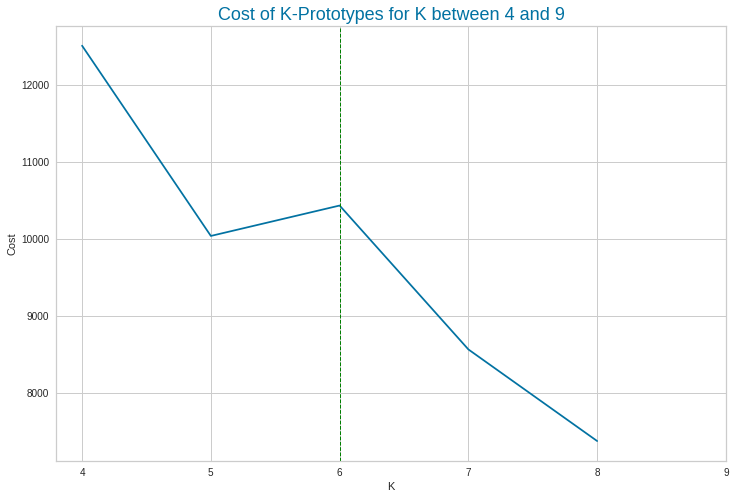

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(cost)
plt.xticks(np.arange(0,6,1), np.arange(4,10,1))
plt.axvline(x=2, linestyle="--", 
            color="green",
            linewidth=1)
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("Cost of K-Prototypes for K between 4 and 9",
          fontsize=18, color="b")
plt.show()

Then we initialize the algorithm with 6 clusters.

In [ ]:
myclust = KPrototypes(n_clusters= 6, init='Cao',n_init=1,verbose=1)
myclust_labels = myclust.fit_predict(X_Pro, categorical=cat_cols)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1433, ncost: 8946.501223981133
Run: 1, iteration: 2/100, moves: 20, ncost: 8946.438712515182
Run: 1, iteration: 3/100, moves: 0, ncost: 8946.438712515182


In [ ]:
# Number of clusters in labels
labels_true = X_Pro.index
n_clusters_ = len(set(myclust_labels)) 

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" 
      % metrics.homogeneity_score(labels_true, myclust_labels))
print("Completeness: %0.4f"
      % metrics.completeness_score(labels_true, myclust_labels))

Estimated number of clusters: 6
Homogeneity: 0.1706
Completeness: 1.0000
Silhouette Coefficient: -0.0508


By comparing the clustering on real data and that carried out on reduced data, we notice that we have a better homogeneity with the second.

**Dbscan**

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
Finds core samples of high density and expands clusters from them. Good 
for data which contains clusters of similar density.

In [ ]:
X = preprocessor.fit((df))
X = preprocessor.transform((df))

In [ ]:
myclust = DBSCAN(eps=0.6, min_samples=8).fit(X)

In [ ]:
labels = myclust.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
labels_true = df.index
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 9
Estimated number of noise points: 162
Homogeneity: 0.0109
Completeness: 1.0000
V-measure: 0.0215
Silhouette Coefficient: -0.1845


___

**Ascending Hierarchical Classification**

Ascending Hierarchical Classification: CAH is an unsupervised algorithm 
well known in Clustering.

In data mining and statistics, hierarchical clustering (also called 
hierarchical cluster analysis or HCA) is a method of cluster analysis 
which seeks to build a hierarchy of clusters. Strategies for 
hierarchical clustering generally fall into two types: 

* Agglomerative: This is a "bottom-up" approach: each observation 
starts in its own cluster, and pairs of clusters are merged as one 
moves up the hierarchy.

* Divisive: This is a "top-down" approach: all observations start in 
one cluster, and splits are performed recursively as one moves down the 
hierarchy.

In [ ]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby',
                 ]
data_numeric = new_data.drop(categories_col ,axis = 1)

**Dendrograms**

We can use a dendrogram to visualize the history of groupings and 

figure out the optimal number of clusters.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(
                  data_numeric, test_size=0.2, random_state=0)

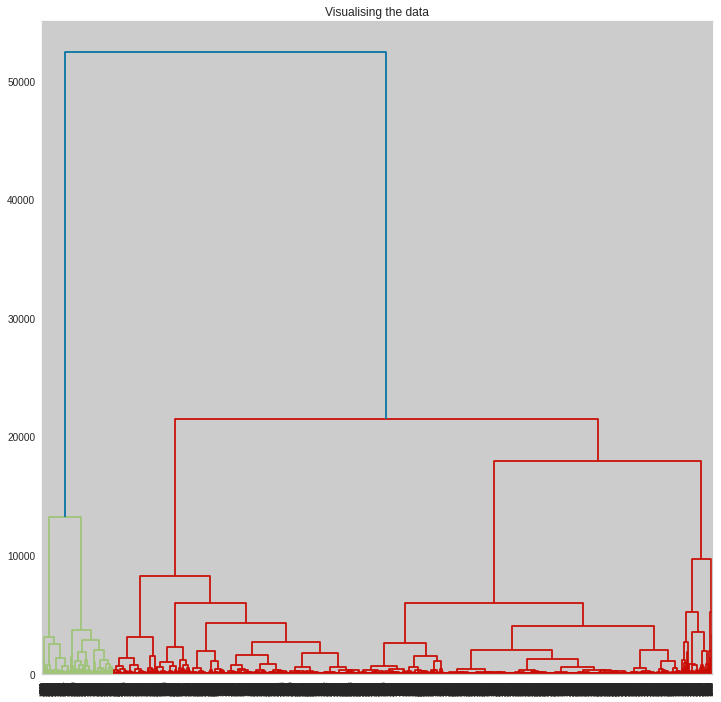

In [ ]:
# Dendograms are used to divide a given cluster into many different clusters.
plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

To determine the optimal number of clusters, we look at the largest 
vertical distance that doesn’t intersect any of the other clusters
we draw a horizontal line at both extremities

The optimal number of clusters is equal to the number of vertical lines 
going through the horizontal line.
So the optimal number is 4.


In [ ]:
# Fit the algorithm with the optimal number ofclusters
myclust = AgglomerativeClustering(n_clusters=4).fit(new_data)

In [ ]:
# Number of clusters in labels, ignoring noise if present.
labels = myclust.labels_
labels_true = new_data.index
n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f" % metrics.silhouette_score(new_data, labels))

Estimated number of clusters: 4
Homogeneity: 0.1034
Completeness: 1.0000
Silhouette Coefficient: 0.5570


In conclusion, we partitioned our customer data set using different 
algorithms including K-Means, K-Prototypes, DBSCAN and Hierarchiqual 
agglomerative clustering according to Ward, the results revolve around 4 to 9 clusters, but the most convincing 
in terms of scores (silhouette Coefficient, Homogeneity and completeness), as well as 
its fit-time, is the K-Means model from which we keep the results.
It is now necessary to identify the professions of each cluster.


## **Analysis of the different clusters**

Now we will train our KMeans with the optimal K selected and assign its 
cluster to each client. Thus, we will be able to analyze the 
differences between each cluster:

In [ ]:
# To remove some columns for a better visualization of clusters
df = df.drop(df[['harvesine_distance', 'mean_payment_sequential']], axis=1)

In [ ]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("kmeans", KMeans(8))])
kmeans_model.fit(df)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
df["kmeans_label"] = kmeans_labels

We will first group the individuals by cluster to analyze the means:

In [ ]:
kmeans_clusters_means = df.groupby("kmeans_label").mean()
kmeans_clusters_means.head(4)

,nb_orders,total_spend,total_freight,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items
kmeans_label,,,,,,,,,,,,,,,,,,
0,1.027597,186.774854,27.029919,3.777067,4.171406,12.840902,5.982254,0.002375,0.022928,0.161054,0.003790,0.097953,0.329675,0.128339,0.074076,0.120275,0.059534,1.205897
1,1.004992,41.434481,16.110791,1.965851,4.231530,11.490624,6.015989,0.013126,0.040746,0.051106,0.015664,0.117077,0.285957,0.124132,0.074676,0.210067,0.067450,1.059396
2,1.012921,532.531640,36.750624,5.477247,4.307022,12.310487,5.976966,0.010112,0.010674,0.219101,0.000562,0.152060,0.251311,0.159551,0.048127,0.101966,0.046536,1.212921
3,1.000000,1251.487120,41.485840,5.328000,4.588000,10.192000,5.912000,0.004000,0.000000,0.184000,0.000000,0.096000,0.328000,0.144000,0.012000,0.204000,0.028000,1.052000


In the first place, it is necessary to scale all points.

In [ ]:
# Scale X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)
X_scaled= pd.DataFrame(X_scaled, index=df.index, columns=df.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,nb_orders,total_spend,total_freight,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items
kmeans_label,,,,,,,,,,,,,,,,,,
0,0.013799,0.039650,0.072026,0.145272,0.792851,0.056655,0.452932,0.002375,0.022928,0.161054,0.003790,0.097953,0.329675,0.128339,0.074076,0.120275,0.059534,0.018718
1,0.002496,0.008655,0.042930,0.075610,0.807882,0.050194,0.455999,0.013126,0.040746,0.051106,0.015664,0.117077,0.285957,0.124132,0.074676,0.210067,0.067450,0.005400
2,0.006461,0.113386,0.097929,0.210663,0.826756,0.054117,0.452451,0.010112,0.010674,0.219101,0.000562,0.152060,0.251311,0.159551,0.048127,0.101966,0.046536,0.019356
3,0.000000,0.266709,0.110546,0.204923,0.897000,0.043981,0.446545,0.004000,0.000000,0.184000,0.000000,0.096000,0.328000,0.144000,0.012000,0.204000,0.028000,0.004727
4,0.008419,0.022335,0.057924,0.114646,0.799846,0.054280,0.459986,0.008139,0.032287,0.101894,0.005656,0.122592,0.331171,0.146529,0.083660,0.094539,0.073533,0.012476
5,0.001309,0.172189,0.098755,0.224854,0.876636,0.048357,0.441218,0.001309,0.010471,0.270942,0.000000,0.071990,0.246073,0.114529,0.028141,0.163613,0.092932,0.008091
6,0.014118,0.068757,0.087810,0.177778,0.803412,0.053259,0.454563,0.003980,0.029531,0.107305,0.000663,0.182869,0.281224,0.136075,0.070431,0.120523,0.067399,0.024532
7,0.000000,0.482466,0.137484,0.176511,0.946429,0.038278,0.391234,0.000000,0.000000,0.196429,0.000000,0.035714,0.535714,0.071429,0.053571,0.107143,0.000000,0.000000


Let's now project these different averages on a Radar plot with the Ploty library to visualize the differences between clusters:

In [ ]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparison of the means by variable of the clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [ ]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Unfortunately here, the segmentation is mainly based on the product categories purchased. The weight of these features hides the other categorization axes, so we will carry out a new K-Means by removing these variables.

**Clustering without product categories**

In [ ]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_num = df.drop(categories_col, axis=1)
X_num.head(6)

,nb_orders,total_spend,total_freight,mean_payment_installments,mean_review_score,delivery_days,favorite_sale_month,total_items,kmeans_label
0,1,129.90,12.00,8.0,5.0,6.0,5,1.0,4
1,1,18.90,8.29,1.0,4.0,3.0,5,1.0,1
2,1,69.00,17.22,8.0,3.0,26.0,3,1.0,1
3,1,25.99,17.63,4.0,4.0,20.0,10,1.0,1
4,1,180.00,16.89,6.0,5.0,13.0,11,1.0,0
5,1,154.00,12.98,8.0,4.0,2.0,4,1.0,0


In [ ]:
# KMeans Pipeline with best K
kmeans_model_num = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(8))])
kmeans_model_num.fit(X_num)

# Kmeans labels
kmeans_labels_num = kmeans_model_num.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_num = scaler.fit_transform(X_num)
X_scaled_num = pd.DataFrame(X_scaled_num, index=X_num.index, columns=X_num.columns)
X_scaled_num["kmeans_label"] = kmeans_labels_num

# Group by cluster
X_scaled_clusters_num = X_scaled_num.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_num,
            group="kmeans_label")

**Business interpretation of clusters**

. Group 0 : These are the customers whose place orders at the end 
of the year with a small number of orders at an poor 
amount with a long delivery_days hence their dissatisfaction.

. Group 1 : These are the customers in the last quarter of the year, who order a lot of items and spend a lot. They are very satisfied and this can be explained by the very limited delivery time.

. Group 2 : These are the beginning of the year customers who don't order a lot or spend a lot and are very satisfied.

. Group 3 : These are the mid-year customers, who don't order a lot or spend a lot, and are very satisfied.

. Group 4 : This group is for the beginning of the year customers who buy a lot of items for a very large sum and who give high reviews score.

. Group 5 : These are the customers who are not very active but who are not satisfied at all because of the very long delivery time.

. Group 6 : These customers spend too much for a very small number of orders and expect a high delivery time, which is why they give poor ratings.

. Group 7 : This group is formed by customers who are always satisfied, in fact, they order moderately at the end of the year.


___

## **K-Means temporal stability**


In order to establish a maintenance contract for the customer segmentation algorithm, we need to test its stability over time and see, for example, when customers change Cluster.

For that, we have to recalculate all the features according to a given period.


In [ ]:
# To make 'order_time' in datetime type
data['order_time'] = pd.to_datetime(data['order_time'], errors='coerce')
data.head(4)

,index,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,order_time,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
0,0,1,129.90,12.00,1.0,8.0,5.0,6.0,2018-05-10,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,210.155490
1,1,1,18.90,8.29,1.0,1.0,4.0,3.0,2018-05-07,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,210.155490
2,2,1,69.00,17.22,1.0,8.0,3.0,26.0,2017-03-10,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,125.481181
3,3,1,25.99,17.63,1.0,4.0,4.0,20.0,2017-10-12,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1571.715882


In [ ]:
data['order_time'] = data['order_time'].dt.date
data.head(2)

,index,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,order_time,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
0,0,1,129.9,12.00,1.0,8.0,5.0,6.0,2018-05-10,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,210.15549
1,1,1,18.9,8.29,1.0,1.0,4.0,3.0,2018-05-07,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,210.15549


In [ ]:
time_delta = int((data['order_time'].max() - data['order_time'].min())/np.timedelta64(1,'M'))
print("The full order period covers {} month.".format(time_delta))

The full order period covers 23 month.


To determine when the clients change cluster, we will iterate the K-Means over the period with 6 month deltas and calculate the ARI score, taking care to compare the same clients (those how have the same harvesine_distance). 

In [ ]:
data_sorted = data.sort_values(by='order_time')
data_sorted.head(2)

,index,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,delivery_days,order_time,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,harvesine_distance
47882,47882,1,134.97,8.49,1.0,1.0,1.0,55.0,2016-09-15,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,210.155490
17361,17361,1,21.90,17.19,1.0,1.0,4.0,24.0,2016-10-03,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,337.135963


In [ ]:
import datetime
x_0 = datetime.datetime(2016, 9, 15)  
x_1 = datetime.datetime(2017, 3, 15)  
x_2 = datetime.datetime(2017, 3, 15)  
x_3 = datetime.datetime(2018, 3, 15)  
                                 

In [ ]:
from dateutil.relativedelta import relativedelta
df_0 = data_sorted[data_sorted['order_time'] < x_0+relativedelta(months=+6)]
df_1 = data_sorted[data_sorted['order_time'] < x_1+relativedelta(months=+6)]
df_2 = data_sorted[data_sorted['order_time'] < x_2+relativedelta(months=+6)]
df_3 = data_sorted[data_sorted['order_time'] < x_3+relativedelta(months=+6)]

In [ ]:
def calcul_model_labels(df):
  scaler = MinMaxScaler()
  scaler.fit(df)
  df_normalized = scaler.transform(df)
  model = KMeans(n_clusters=8, random_state=42)
  model.fit(df_normalized)

  return model.labels_

In [ ]:
calcul_model_labels(df=data)
labels_base = calcul_model_labels(df=data)
labels_base

data["label"] = labels_base

In [ ]:
df_0['order_time'] = df_0['order_time'].values.astype(float)

In [ ]:
calcul_model_labels(df=df_0)
labels_df_0 = calcul_model_labels(df=df_0)
labels_df_0

df_0["label"] = labels_df_0

In [ ]:
df_1['order_time'] = df_1['order_time'].values.astype(float)

In [ ]:
calcul_model_labels(df=df_1)
labels_df_1 = calcul_model_labels(df=df_1)
labels_df_1

df_1["label"] = labels_df_1

In [ ]:
df_2['order_time'] = df_2['order_time'].values.astype(float)

In [ ]:
calcul_model_labels(df=df_2)
labels_df_2 = calcul_model_labels(df=df_2)
labels_df_2

df_2["label"] = labels_df_2

In [ ]:
df_3['order_time'] = df_3['order_time'].values.astype(float)

In [ ]:
calcul_model_labels(df=df_3)
labels_df_3 = calcul_model_labels(df=df_3)
labels_df_3

df_3["label"] = labels_df_3

In [ ]:
# Filter on initial customer client
df_0 = df_0[df_0['harvesine_distance'].isin(data['harvesine_distance'])]

In [ ]:
# Filter on initial customer client
df_1 = df_1[df_1['harvesine_distance'].isin(data['harvesine_distance'])]

In [ ]:
# Filter on initial customer client
df_2 = df_2[df_2['harvesine_distance'].isin(data['harvesine_distance'])]

In [ ]:
# Filter on initial customer client
df_3 = df_3[df_3['harvesine_distance'].isin(data['harvesine_distance'])]

In [ ]:
model = KMeans(5, random_state=42)
ari_lst=[]
for df in [df_0, df_1, df_2, df_3]:
  calcul_model_labels(df)
  ari_lst.append(adjusted_rand_score(labels_true.values, labels_pred))

In [ ]:
ari_score = []
for p in np.arange(2,(time_delta-6),2):
  for df in [df_0, df_1, df_2, df_3]:
    calcul_model_labels(df)
  
    # Calculate ARI score
    ari_p = adjusted_rand_score(labels_pred, labels_true)
    ari_score.append([p,ari_p])

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

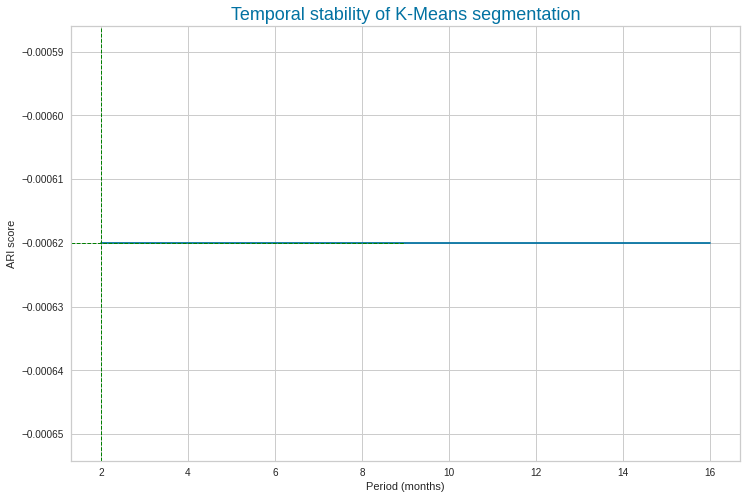

In [ ]:
ari_score = pd.DataFrame(ari_score, columns=["period", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="period", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Period (months)")
plt.ylabel("ARI score")
plt.title("Temporal stability of K-Means segmentation",
          fontsize=18,
          color="b")
plt.show()
